#Import Statements

In [1]:
#data manipulation
import pandas as pd
import datetime
import numpy as np
import random

#vis
import matplotlib.pyplot as plt

#keras
import tensorflow
from tensorflow import keras
from keras import losses
from keras.models import Input, Model, Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.callbacks import EarlyStopping
from keras.initializers import RandomNormal


In [2]:
df = pd.read_csv("philly2.csv")
df.drop('Sunrise', inplace=True, axis=1)
df.drop('Sunset', inplace=True, axis=1)
df.drop('Altitude', inplace=True, axis=1)
df.drop('Dew Point Temp', inplace=True, axis=1)
df.drop('Precipitation', inplace=True, axis=1)
df.drop('Pressure Change', inplace=True, axis=1)

df.drop('Station Pressure', inplace=True, axis=1)
df.drop('Visibility', inplace=True, axis=1)
df.drop('Wet Bulb Temp', inplace=True, axis=1)
df.drop('Wind Direction', inplace=True, axis=1)
df.drop('Sky Conditions', inplace=True, axis=1)
df.drop('Pressure Tendency', inplace=True, axis=1)
df.head()

,DATE,Dry Bulb Temp,Humidity,Wind Speed
0,"January 1, 2018, 00:54",10.0,50.0,6.0
1,"January 1, 2018, 01:00",10.0,50.0,6.0
2,"January 1, 2018, 01:54",9.0,52.0,7.0
3,"January 1, 2018, 02:54",10.0,48.0,8.0
4,"January 1, 2018, 03:54",9.0,50.0,7.0


In [4]:
df = df.dropna(how='any',axis=0)

DATE             39439
Dry Bulb Temp    39439
Humidity         39439
Wind Speed       39439
dtype: int64

In [6]:
#converting to datetime
df['DATE'] = [datetime.datetime.strptime(x,"%B %d, %Y, %H:%M") for x in df["DATE"]]

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39439 entries, 0 to 40587
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   DATE           39439 non-null  datetime64[ns]
 1   Dry Bulb Temp  39439 non-null  float64       
 2   Humidity       39439 non-null  float64       
 3   Wind Speed     39439 non-null  float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 1.5 MB


In [8]:
#seperating the hour 
df["hour"] = [x.hour for x in df["DATE"]]

#set hour to a sin and cosine function so that 23 and 0 are connected in the seqauence of data
df["cosDay"] = [np.cos(x * (2 * np.pi / 24)) for x in df["hour"]]
df["sinDay"] = [np.sin(x * (2 * np.pi / 24)) for x in df["hour"]]
df.head(24)

,DATE,Dry Bulb Temp,Humidity,Wind Speed,hour,cosDay,sinDay
0,2018-01-01 00:54:00,10.0,50.0,6.0,0,1.000000e+00,0.000000e+00
1,2018-01-01 01:00:00,10.0,50.0,6.0,1,9.659258e-01,2.588190e-01
2,2018-01-01 01:54:00,9.0,52.0,7.0,1,9.659258e-01,2.588190e-01
3,2018-01-01 02:54:00,10.0,48.0,8.0,2,8.660254e-01,5.000000e-01
4,2018-01-01 03:54:00,9.0,50.0,7.0,3,7.071068e-01,7.071068e-01
5,2018-01-01 04:54:00,9.0,50.0,9.0,4,5.000000e-01,8.660254e-01
6,2018-01-01 05:54:00,9.0,50.0,8.0,5,2.588190e-01,9.659258e-01
7,2018-01-01 06:54:00,7.0,57.0,7.0,6,6.123234e-17,1.000000e+00
8,2018-01-01 07:00:00,7.0,57.0,7.0,7,-2.588190e-01,9.659258e-01
9,2018-01-01 07:54:00,8.0,57.0,8.0,7,-2.588190e-01,9.659258e-01


In [9]:
#extract timestamp
df["tstamp"] = [x.timestamp() for x in df["DATE"]]

secDay = 24*60*60
secYear = (365.25) * secDay

df["month_cos"] = [np.cos((x) * (2 * np.pi / secYear)) for x in df["tstamp"]]
df["month_sin"] = [np.sin((x) * (2 * np.pi / secYear)) for x in df["tstamp"]]


In [10]:
def createXY(ts: np.array, lag=1, n_ahead=1, target_index=0) -> tuple:
    
    n_features = ts.shape[1]
    
    X, Y = [],[]
    
    if len(ts) - lag <= 0:
        X.append(ts)
    else:
        for i in range(len(ts) - lag - n_ahead):
            Y.append(ts[(i + lag):(i + lag + n_ahead), target_index])
            X.append(ts[i:(i + lag)])
    
    X, Y = np.array(X), np.array(Y)

    # Reshaping the X array to an RNN input shape 
    X = np.reshape(X, (X.shape[0], lag, n_features))
    

    return X, Y

In [56]:
#number of previos hours to use in forcast
lag = 24

#steps
n_ahead = 12

#test %
test_share = 0.1

#training epochs
epochs = 200

#batch size
batch = 52
#learning rate
lr = 0.0001

#nuerones used for LSTM layer
n_layer = 30

#features being used
features = ['Dry Bulb Temp', 'cosDay', 'sinDay', 'month_sin', 'month_cos', 'Wind Speed', 'Humidity']

In [117]:
class NNMultistepModel():
    
    def __init__(
        self, 
        X, 
        Y, 
        n_outputs,
        n_lag,
        n_ft,
        n_layer,
        batch,
        epochs, 
        lr,
        Xval=None,
        Yval=None,
        mask_value=-999.0,
        min_delta=0.001,
        patience=5
    ):
        lstm_input = Input(shape=(n_lag, n_ft))

        # Series signal 
        lstm_layer = LSTM(n_layer, activation='relu')(lstm_input)

        x = Dense(n_outputs)(lstm_layer)
        
        self.model = Model(inputs=lstm_input, outputs=x)
        self.batch = batch 
        self.epochs = epochs
        self.n_layer=n_layer
        self.lr = lr 
        self.Xval = Xval
        self.Yval = Yval
        self.X = X
        self.Y = Y
        self.mask_value = mask_value
        self.min_delta = min_delta
        self.patience = patience

    def trainCallback(self):
        return EarlyStopping(monitor='loss', patience=self.patience, min_delta=self.min_delta)

    def train(self):
        # Getting the untrained model 
        empty_model = self.model
        
        # Initiating the optimizer
        optimizer = keras.optimizers.Adam(learning_rate=self.lr)

        # Compiling the model
        empty_model.compile(loss=losses.MeanAbsoluteError(), optimizer=optimizer)

        if (self.Xval is not None) & (self.Yval is not None):
            history = empty_model.fit(
                self.X, 
                self.Y, 
                epochs=self.epochs, 
                batch_size=self.batch, 
                validation_data=(self.Xval, self.Yval), 
                shuffle=False,
                callbacks=[self.trainCallback()]
            )
        else:
            history = empty_model.fit(
                self.X, 
                self.Y, 
                epochs=self.epochs, 
                batch_size=self.batch,
                shuffle=False,
                callbacks=[self.trainCallback()]
            )
        
        # Saving to original model attribute in the class
        self.model = empty_model
        
        # Returning the training history
        return history
    
    def predict(self, X):
        return self.model.predict(X)

In [118]:
# Subseting only the needed columns 
ts = df[features]
nrows = ts.shape[0]
# Spliting into train and test sets
train = ts[0:int(nrows * (1 - 0.1))]
test = ts[int(nrows * (1 - 0.1)):]
# Scaling the data 
train_mean = train.mean()
train_std = train.std()
train = (train - train_mean) / train_std
test = (test - train_mean) / train_std
# Creating the final scaled frame 
ts_s = pd.concat([train, test])
# Creating the X and Y for training
X, Y = createXY(ts_s.values, lag=lag, n_ahead=n_ahead)
n_ft = X.shape[2]

In [119]:
# Spliting into train and test sets 
Xtrain, Ytrain = X[0:int(X.shape[0] * (1 - test_share))], Y[0:int(X.shape[0] * (1 - test_share))]
Xval, Yval = X[int(X.shape[0] * (1 - test_share)):], Y[int(X.shape[0] * (1 - test_share)):]

In [120]:
len(Xval)

3941

In [121]:
# Initiating the model object
model = NNMultistepModel(
 X=Xtrain,
 Y=Ytrain,
 n_outputs=n_ahead,
 n_lag=lag,
 n_ft=n_ft,
 n_layer=n_layer,
 batch=batch,
 epochs=epochs, 
 lr=lr,
 Xval=Xval,
 Yval=Yval,
)
# Training of the model 
history = model.train()

Epoch 1/200
682/682 [==============================] - 4s 5ms/step - loss: 0.8356 - val_loss: 0.4281
Epoch 2/200
682/682 [==============================] - 3s 4ms/step - loss: 0.4628 - val_loss: 0.3296
Epoch 3/200
682/682 [==============================] - 3s 4ms/step - loss: 0.3308 - val_loss: 0.2953
Epoch 4/200
682/682 [==============================] - 3s 4ms/step - loss: 0.2786 - val_loss: 0.2690
Epoch 5/200
682/682 [==============================] - 3s 4ms/step - loss: 0.2468 - val_loss: 0.2487
Epoch 6/200
682/682 [==============================] - 3s 5ms/step - loss: 0.2290 - val_loss: 0.2326
Epoch 7/200
682/682 [==============================] - 3s 5ms/step - loss: 0.2156 - val_loss: 0.2214
Epoch 8/200
682/682 [==============================] - 3s 5ms/step - loss: 0.2052 - val_loss: 0.2142
Epoch 9/200
682/682 [==============================] - 3s 5ms/step - loss: 0.1970 - val_loss: 0.2100
Epoch 10/200
682/682 [==============================] - 3s 5ms/step - loss: 0.1905 - val_lo

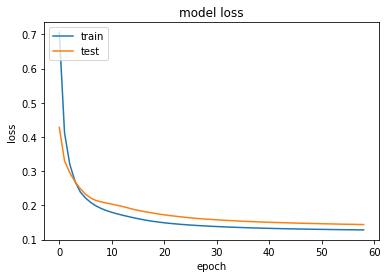

In [122]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [123]:
# Comparing the forecasts with the actual values
yhat = [x[0] for x in model.predict(Xval)]
y = [y[0] for y in Yval]
# Creating the frame to store both predictions
days = df['DATE'].values[-len(y):]
frame = pd.concat([
 pd.DataFrame({'day': days, 'Dry Bulb Temp': y, 'type': 'original'}),
 pd.DataFrame({'day': days, 'Dry Bulb Temp': yhat, 'type': 'forecast'})
])
# Creating the unscaled values column
frame['temp_absolute'] = [(x * train_std['Dry Bulb Temp']) + train_mean['Dry Bulb Temp'] for x in frame['Dry Bulb Temp']]
# Pivoting
pivoted = frame.pivot_table(index='day', columns='type')
pivoted.columns = ['_'.join(x).strip() for x in pivoted.columns.values]
pivoted['res'] = pivoted['temp_absolute_original'] - pivoted['temp_absolute_forecast']
pivoted['res_abs'] = [abs(x) for x in pivoted['res']]

In [124]:
frame

,day,Dry Bulb Temp,type,temp_absolute
0,2020-09-10 12:40:00,0.878723,original,73.000000
1,2020-09-10 12:54:00,0.935087,original,74.000000
2,2020-09-10 13:00:00,0.935087,original,74.000000
3,2020-09-10 13:54:00,0.991451,original,75.000000
4,2020-09-10 14:54:00,0.991451,original,75.000000
...,...,...,...,...
3936,2020-12-31 19:54:00,-0.568745,forecast,47.319150
3937,2020-12-31 20:54:00,-0.563099,forecast,47.419324
3938,2020-12-31 21:54:00,-0.510564,forecast,48.351404
3939,2020-12-31 22:54:00,-0.552628,forecast,47.605109


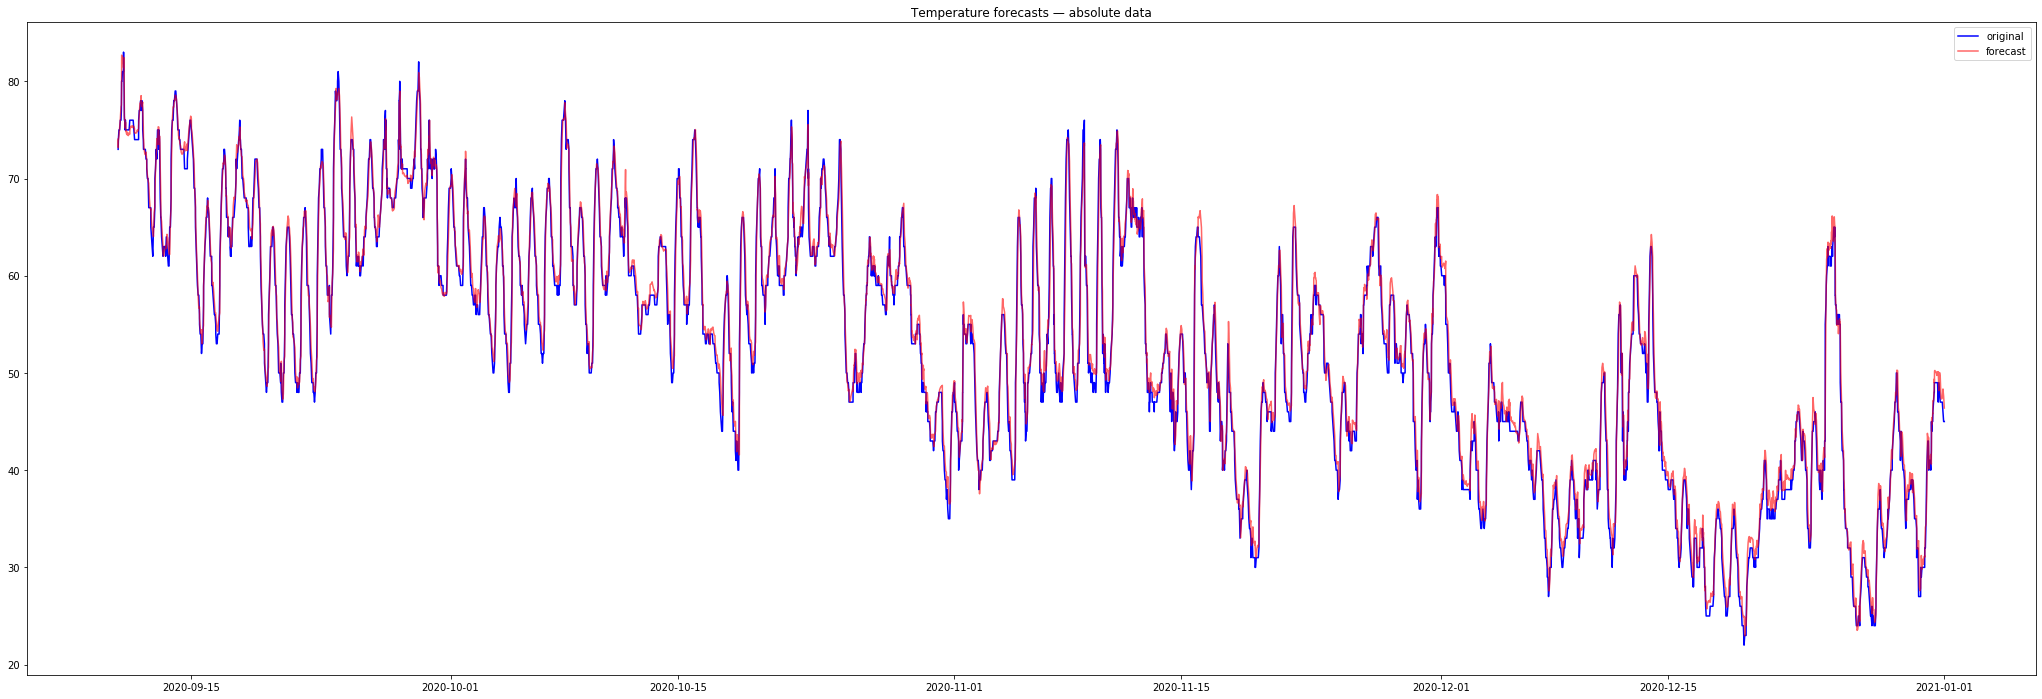

In [125]:
plt.figure(figsize=(36, 12))
plt.plot(pivoted.index, pivoted.temp_absolute_original, color='blue', label='original')
plt.plot(pivoted.index, pivoted.temp_absolute_forecast, color='red', label='forecast', alpha=0.6)
plt.title('Temperature forecasts — absolute data')
plt.legend()
plt.show()


In [126]:
df.head()

,DATE,Dry Bulb Temp,Humidity,Wind Speed,hour,cosDay,sinDay,tstamp,month_cos,month_sin
0,2018-01-01 00:54:00,10.0,50.0,6.0,0,1.000000,0.000000,1.514768e+09,1.000000,0.000645
1,2018-01-01 01:00:00,10.0,50.0,6.0,1,0.965926,0.258819,1.514768e+09,1.000000,0.000717
2,2018-01-01 01:54:00,9.0,52.0,7.0,1,0.965926,0.258819,1.514772e+09,0.999999,0.001362
3,2018-01-01 02:54:00,10.0,48.0,8.0,2,0.866025,0.500000,1.514775e+09,0.999998,0.002079
4,2018-01-01 03:54:00,9.0,50.0,7.0,3,0.707107,0.707107,1.514779e+09,0.999996,0.002795


In [127]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39439 entries, 0 to 40587
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   DATE           39439 non-null  datetime64[ns]
 1   Dry Bulb Temp  39439 non-null  float64       
 2   Humidity       39439 non-null  float64       
 3   Wind Speed     39439 non-null  float64       
 4   hour           39439 non-null  int64         
 5   cosDay         39439 non-null  float64       
 6   sinDay         39439 non-null  float64       
 7   tstamp         39439 non-null  float64       
 8   month_cos      39439 non-null  float64       
 9   month_sin      39439 non-null  float64       
dtypes: datetime64[ns](1), float64(8), int64(1)
memory usage: 3.3 MB


In [128]:
temp = pd.read_csv("test.csv")


In [129]:
temp.head()

,Unnamed: 0,dt,temp,humidity,wind_speed,wind_gust
0,0,1636070400,281.82,42,1.88,4.18
1,1,1636074000,281.45,46,1.76,4.10
2,2,1636077600,280.81,50,1.66,3.82
3,3,1636081200,280.39,53,1.76,4.03
4,4,1636084800,278.55,62,0.89,1.79


In [130]:
temp.drop('Unnamed: 0', inplace=True, axis=1)
temp.drop('wind_gust', inplace=True, axis=1)




In [131]:

temp.head()

,dt,temp,humidity,wind_speed
0,1636070400,281.82,42,1.88
1,1636074000,281.45,46,1.76
2,1636077600,280.81,50,1.66
3,1636081200,280.39,53,1.76
4,1636084800,278.55,62,0.89


In [132]:
temp['dt'] = pd.to_datetime(temp['dt'],unit='s')

In [133]:
temp.head()

,dt,temp,humidity,wind_speed
0,2021-11-05 00:00:00,281.82,42,1.88
1,2021-11-05 01:00:00,281.45,46,1.76
2,2021-11-05 02:00:00,280.81,50,1.66
3,2021-11-05 03:00:00,280.39,53,1.76
4,2021-11-05 04:00:00,278.55,62,0.89


In [134]:
temp["hour"] = [x.hour for x in temp["dt"]]

#set hour to a sin and cosine function so that 23 and 0 are connected in the seqauence of data
temp["cosDay"] = [np.cos(x * (2 * np.pi / 24)) for x in temp["hour"]]
temp["sinDay"] = [np.sin(x * (2 * np.pi / 24)) for x in temp["hour"]]

In [135]:
temp["tstamp"] = [x.timestamp() for x in temp["dt"]]

secDay = 24*60*60
secYear = (365.25) * secDay

temp["month_cos"] = [np.cos((x) * (2 * np.pi / secYear)) for x in temp["tstamp"]]
temp["month_sin"] = [np.sin((x) * (2 * np.pi / secYear)) for x in temp["tstamp"]]


In [136]:
temp = temp.rename(columns={"dt": "DATE", "temp": "Dry Bulb Temp", "humidity": "Humidity", "wind_speed": "Wind Speed"})
temp.head()

,DATE,Dry Bulb Temp,Humidity,Wind Speed,hour,cosDay,sinDay,tstamp,month_cos,month_sin
0,2021-11-05 00:00:00,281.82,42,1.88,0,1.000000,0.000000,1.636070e+09,0.556576,-0.830797
1,2021-11-05 01:00:00,281.45,46,1.76,1,0.965926,0.258819,1.636074e+09,0.557171,-0.830398
2,2021-11-05 02:00:00,280.81,50,1.66,2,0.866025,0.500000,1.636078e+09,0.557766,-0.829998
3,2021-11-05 03:00:00,280.39,53,1.76,3,0.707107,0.707107,1.636081e+09,0.558361,-0.829598
4,2021-11-05 04:00:00,278.55,62,0.89,4,0.500000,0.866025,1.636085e+09,0.558955,-0.829198


In [137]:
df.info()
type(df)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39439 entries, 0 to 40587
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   DATE           39439 non-null  datetime64[ns]
 1   Dry Bulb Temp  39439 non-null  float64       
 2   Humidity       39439 non-null  float64       
 3   Wind Speed     39439 non-null  float64       
 4   hour           39439 non-null  int64         
 5   cosDay         39439 non-null  float64       
 6   sinDay         39439 non-null  float64       
 7   tstamp         39439 non-null  float64       
 8   month_cos      39439 non-null  float64       
 9   month_sin      39439 non-null  float64       
dtypes: datetime64[ns](1), float64(8), int64(1)
memory usage: 3.3 MB


pandas.core.frame.DataFrame

In [138]:
temp.info()
type(temp)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   DATE           24 non-null     datetime64[ns]
 1   Dry Bulb Temp  24 non-null     float64       
 2   Humidity       24 non-null     int64         
 3   Wind Speed     24 non-null     float64       
 4   hour           24 non-null     int64         
 5   cosDay         24 non-null     float64       
 6   sinDay         24 non-null     float64       
 7   tstamp         24 non-null     float64       
 8   month_cos      24 non-null     float64       
 9   month_sin      24 non-null     float64       
dtypes: datetime64[ns](1), float64(7), int64(2)
memory usage: 2.0 KB


pandas.core.frame.DataFrame

In [139]:
model.predict(Xval)

array([[ 0.9375882 ,  0.9613849 ,  0.99768615, ...,  1.1693052 ,
         1.1315259 ,  1.1321336 ],
       [ 0.8887228 ,  0.92488384,  0.9922272 , ...,  1.1851573 ,
         1.1711556 ,  1.1932389 ],
       [ 0.9291276 ,  0.9459548 ,  0.9887667 , ...,  1.205394  ,
         1.1813986 ,  1.1994705 ],
       ...,
       [-0.5105636 , -0.4624692 , -0.5907134 , ..., -0.58951265,
        -0.63325113, -0.6467682 ],
       [-0.55262756, -0.5244012 , -0.62756187, ..., -0.6627037 ,
        -0.70139265, -0.7266854 ],
       [-0.6211598 , -0.59933627, -0.71617043, ..., -0.80308115,
        -0.8233494 , -0.87219673]], dtype=float32)

In [140]:
pred = temp[features]

In [141]:
pred_mean = pred.mean()
pred_std = pred.std()
pred= (pred - pred_mean) / pred_std

In [142]:
Xpred = createXY(pred.values, lag=lag, n_ahead=n_ahead)

In [143]:
records = pred.to_records(index=False)
result = list(records)
print(result)

[(0.45253455, 1.38443731, 4.80323181e-17, -1.62006279, -1.6292521, 1.25076862, -1.02490003), (0.33762157, 1.33726375, 0.35831874, -1.48028061, -1.48707389, 1.0598723, -0.68444881), (0.13885318, 1.19895788, 0.69221866, -1.34034903, -1.34496403, 0.90079203, -0.34399759), (0.00841142, 0.97894501, 0.97894501, -1.20026811, -1.20292261, 1.0598723, -0.08865917), (-0.56304771, 0.69221866, 1.19895788, -1.06003794, -1.0609497, -0.32412605, 0.67735607), (-0.69970098, 0.35831874, 1.33726375, -0.91965857, -0.91904536, -0.32412605, 0.67735607), (-0.83635425, 2.44880063e-16, 1.38443731, -0.7791301, -0.77720968, -0.32412605, 0.76246888), (-0.95437298, -0.35831874, 1.33726375, -0.63845258, -0.63544273, -0.32412605, 0.76246888), (-1.11276654, -0.69221866, 1.19895788, -0.49762608, -0.49374457, -0.32412605, 0.93269449), (-1.22457377, -0.97894501, 0.97894501, -0.35665069, -0.35211529, -1.02407924, 1.1029201), (-1.31774645, -1.19895788, 0.69221866, -0.21552648, -0.21055494, -0.32412605, 1.1029201), (-1.2960

In [144]:
pred.shape

(24, 7)

In [145]:
len(result)

24

In [146]:
model.predict(pred)

ValueError: in user code:

    C:\Users\gtray\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1478 predict_function  *
        return step_function(self, iterator)
    C:\Users\gtray\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1468 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\gtray\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\gtray\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\gtray\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\gtray\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1461 run_step  **
        outputs = model.predict_step(data)
    C:\Users\gtray\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1434 predict_step
        return self(x, training=False)
    C:\Users\gtray\anaconda3\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    C:\Users\gtray\anaconda3\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:274 assert_input_compatibility
        ', found shape=' + display_shape(x.shape))

    ValueError: Input 0 is incompatible with layer model_2: expected shape=(None, 24, 7), found shape=(None, 7)


In [111]:
model.summary()

AttributeError: 'NNMultistepModel' object has no attribute 'summary'